In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pickle
from siamese import SiameseRNN
from scipy import spatial
import nltk
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

%matplotlib inline



In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
max_length = 15

# tensorflow model
checkpoint_path = 'checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400'

model_parameters = {}
model_parameters['rnn_type'] = 'lstm'
model_parameters['dropout'] = 0
model_parameters['padding'] = 'right'
model_parameters['sequence_length'] = 15
model_parameters['opt'] = 'adam'
model_parameters['learning_rate'] = 0.01
model_parameters['max_steps'] = 80000
model_parameters['n_input'] = 300
model_parameters['n_hidden'] = 50
model_parameters['rnn_layers'] = 1
model_parameters['batch_size'] = 128
model_parameters['distance_threshold'] = 0.5
model_parameters['loss'] = 'manhattan'

#Create tensorflow model and train
print('Create model...')
model = SiameseRNN(model_parameters)

Create model...


C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Train 

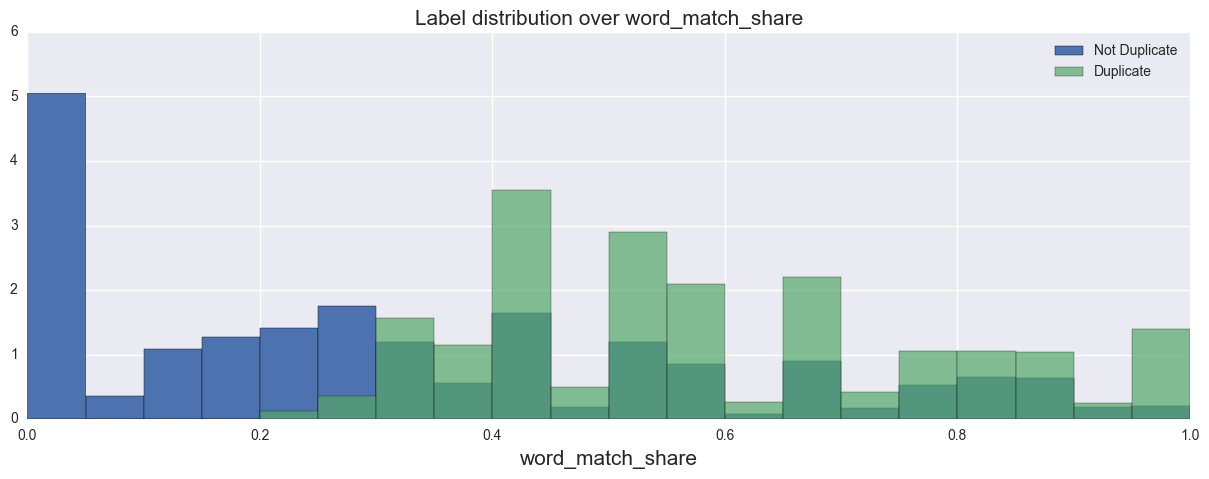

In [4]:
# Word match

from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

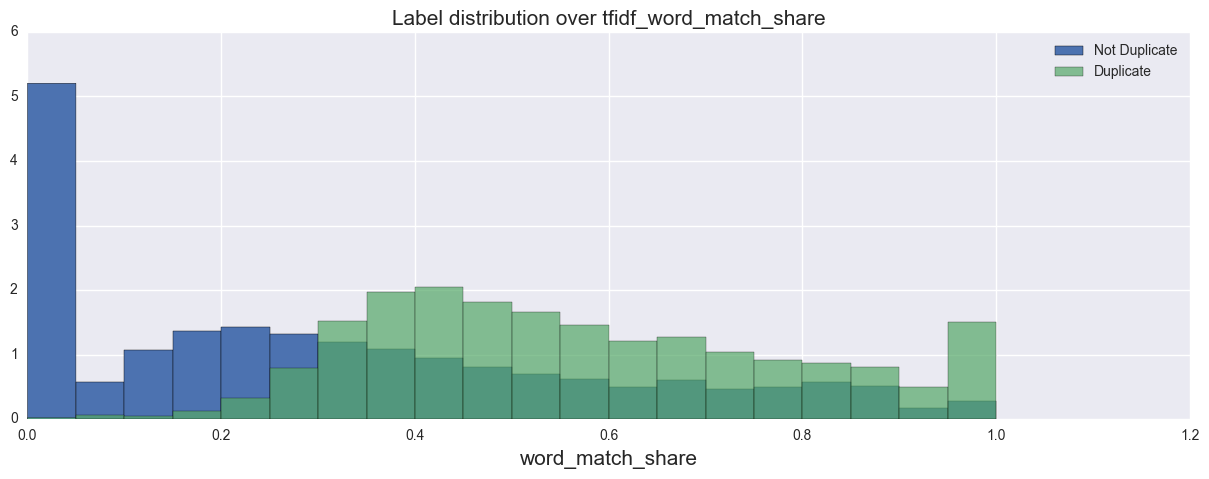

In [5]:
# tf-idf

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [6]:
# Here we should add the similarity and/or distance
def obtain_similarities(max_length, checkpoint_path, model_parameters, num_total_files, set_to_obtain):

    
    
    if set_to_obtain == 'train':
        num_samples = len(df_train)
    elif set_to_obtain == 'test':
        num_samples = len(df_test)
    similarities = np.zeros((num_samples), np.float32)
    
    idx_similarities = 0
    for i in range(num_total_files):
        # Load training pickles
        with open('pickles/X_' + set_to_obtain + '_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_1 = pickle.load(handle)
        with open('pickles/X_' + set_to_obtain + '_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_2 = pickle.load(handle) 
        # Compute similarities
        similarities_batch, h1, h2 = model.get_distances_and_hidden(X_train_1, X_train_2, np.zeros(len(X_train_1), np.int8), checkpoint_path)
        similarities[idx_similarities:(idx_similarities + len(similarities_batch))] = similarities_batch
        idx_similarities += len(similarities_batch)
        print(i)

    return similarities

def obtain_similarities_and_other_features(max_length, checkpoint_path, model_parameters, num_total_files, set_to_obtain, size_hidden):

    if set_to_obtain == 'train':
        num_samples = len(df_train)
    elif set_to_obtain == 'test':
        num_samples = len(df_test)
    
    similarities = np.zeros((num_samples), np.float32)
    difference_hidden = np.zeros((num_samples, size_hidden), np.float32)
    multwise_hidden = np.zeros((num_samples, size_hidden), np.float32)
    
    idx = 0
    for i in range(num_total_files):
        # Load training pickles
        with open('pickles/X_' + set_to_obtain + '_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_1 = pickle.load(handle)
        with open('pickles/X_' + set_to_obtain + '_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
            X_train_2 = pickle.load(handle) 
        # Compute similarities
        similarities_batch, h1, h2 = model.get_distances_and_hidden(X_train_1, X_train_2, np.zeros(len(X_train_1), np.int8), checkpoint_path)
        similarities[idx:(idx + len(similarities_batch))] = similarities_batch
        difference_hidden[idx:(idx + len(similarities_batch))] = np.abs(h1 - h2)
        multwise_hidden[idx:(idx + len(similarities_batch))] = h1 * h2
        idx += len(similarities_batch)

    return similarities, difference_hidden, multwise_hidden

In [7]:
#Features from this script: https://www.kaggle.com/the1owl/quora-question-pairs/matching-que-for-quora-end-to-end-0-33719-pb

def get_noun_match(df):
    print('Computing noun match feature...')
    df['question1_nouns'] = df.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df['question2_nouns'] = df.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df['z_noun_match'] = df.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long
    return df['z_noun_match'].values

def get_character_len(df): #Include also the caracther length difference?
    print('Computing character len feature...')
    df['z_len1'] = df.question1.map(lambda x: len(str(x)))
    df['z_len2'] = df.question2.map(lambda x: len(str(x)))
    df['z_len_diff'] = np.abs(df['z_len1'].values - df['z_len2'].values)
    return df['z_len1'].values, df['z_len2'].values, df['z_len_diff']


def get_word_len(df): #Include also the word length difference?
    print('Computing word length feature...')
    df['z_word_len1'] = df.question1.map(lambda x: len(str(x).split()))
    df['z_word_len2'] = df.question2.map(lambda x: len(str(x).split()))
    df['z_word_len_diff'] = np.abs(df['z_word_len1'].values - df['z_word_len2'].values)
    return df['z_word_len1'].values, df['z_word_len2'].values, df['z_word_len_diff'].values


def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()
    
def get_match_ratio(df):
    print('Computing match ration feature...')
    df['z_match_ratio'] = df.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  #takes long
    return df['z_match_ratio'].values

def get_tfidf_aux(df, tfidf):
    
    df['z_tfidf_sum1'] = df.question1.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df['z_tfidf_sum2'] = df.question2.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df['z_tfidf_mean1'] = df.question1.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df['z_tfidf_mean2'] = df.question2.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df['z_tfidf_len1'] = df.question1.map(lambda x: len(tfidf.transform([str(x)]).data))
    df['z_tfidf_len2'] = df.question2.map(lambda x: len(tfidf.transform([str(x)]).data))
    
    #z1 = tfidf.transform(df.question1)
    #z2 = tfidf.transform(df.question2)

    #df['z_tfidf_sum1'] = z1.sum(axis = 1)
    #df['z_tfidf_sum2'] = z2.sum(axis = 1)
    #df['z_tfidf_len1'] = z1.sign().sum(axis = 1)
    #df['z_tfidf_len2'] = z2.sign().sum(axis = 1)
    #df['z_tfidf_mean1'] = df['z_tfidf_sum1']/df['z_tfidf_len1']
    #df['z_tfidf_mean2'] = df['z_tfidf_sum2']/df['z_tfidf_len2']
    
    return df['z_tfidf_sum1'], df['z_tfidf_sum2'], df['z_tfidf_len1'], df['z_tfidf_len2'], df['z_tfidf_mean1'], df['z_tfidf_mean2']
    

In [48]:
# Features with embeddings
def get_features_with_embeddings(df):
    # Stop words in English
    stops = set(stopwords.words("english"))

    i = 0

    bow_sum1 = np.zeros(len(df), dtype=np.float32)
    bow_sum2 = np.zeros(len(df), dtype=np.float32)
    bow_mean1 = np.zeros(len(df), dtype=np.float32)
    bow_mean2 = np.zeros(len(df), dtype=np.float32)
    cosine_sim = np.zeros(len(df), dtype=np.float32)
    hamming = np.zeros(len(df), dtype=np.float32)
    #kl_divergence = np.zeros(len(df), dtype=np.float32)
    pearson = np.zeros(len(df), dtype=np.float32)
    
    print('start')
    for index, row in df.iterrows():
        # Get embeddings
        embedding1 = np.zeros((max_length, 300), dtype=np.float32)
        embedding2 = np.zeros((max_length, 300), dtype=np.float32)

        try:
            # Get tokens of sentences and filter stop words
            tokens1 = nltk.word_tokenize(row['question1'])
            tokens1 = [word for word in tokens1 if word not in stops]
            tokens2 = nltk.word_tokenize(row['question2'])
            tokens2 = [word for word in tokens2 if word not in stops]
            # Get word vector for every word
            for j in range(max_length):
                if j < len(tokens1):
                    if tokens1[j] in model:
                        embedding1[j,:] = model[tokens1[j]] #What to do when word does not exist?
                if j < len(tokens2):
                    if tokens2[j] in model:
                        embedding2[j,:] = model[tokens2[j]] #What to do when word does not exist?
                if (j > len(tokens1)) and (j > len(tokens2)):
                    break
            i += 1
            if i % 10000 == 0:
                print(i)
        except Exception as e:
            print(e)
        # Compute features
        bow_sum1 = np.sum(embedding1)
        bow_sum2 = np.sum(embedding2)
        bow_mean1 = np.mean(embedding1)
        bow_mean2 = np.mean(embedding2)
        cosine_sim = 1 - spatial.distance.cosine(embedding1, embedding2)
        hamming = 1 - spatial.distance.hamming(embedding1, embedding2)
        #kl_divergence = stats.entropy(pk, qk=None, base=None)
        pearson = stats.pearsonr(embedding1, embedding2)
        
    return bow_sum1, bow_sum2, bow_mean1, bow_mean2, cosine_sim, hamming, pearson

In [ ]:

# Better execute next to obtain extra features
num_total_files = 9
set_to_obtain = 'train'
similarities = obtain_similarities(max_length, checkpoint_path, model_parameters, num_total_files, set_to_obtain)


    

In [8]:
num_total_files = 9
set_to_obtain = 'train'
similarities, difference_hidden, multwise_hidden = obtain_similarities_and_other_features(max_length, checkpoint_path, model_parameters, num_total_files, set_to_obtain, model_parameters['n_hidden'])



load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_b

In [31]:
difference_hidden[:,0].shape

(404290,)

# Compute features and save dataframe

In [29]:
x_train = pd.DataFrame()

x_train['word_match'] = train_word_match

x_train['tfidf_word_match'] = tfidf_train_word_match

x_train['noun_match'] = get_noun_match(df_train)


    
x_train['character_len_1'], x_train['character_len_2'] = get_character_len(df_train)

x_train['word_len_1'], x_train['word_len_2'] = get_word_len(df_train)
x_train['match_ratio'] = get_match_ratio(df_train)

df_test = pd.read_csv('test.csv')
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidf_txt = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist() + df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
tfidf.fit_transform(tfidf_txt)
x_train['z_tfidf_sum1'], x_train['z_tfidf_sum2'], x_train['z_tfidf_len1'], x_train['z_tfidf_len2'], x_train['z_tfidf_mean1'], x_train['z_tfidf_mean2'] = get_tfidf_aux(df_train, tfidf)

#x_train['bow_sum1'], x_train['bow_sum2'], x_train['bow_mean1'], x_train['bow_mean2'], x_train['cosine_sim'], x_train['hamming'], x_train['pearson'] = get_features_with_embeddings(df_train)


#x_train['similarity'] = similarities # test with and without this feature

#for i in range(difference_hidden.shape[1]):
    #x_train['difference_hidden_' + str(i)] = difference_hidden[:,i]

#for i in range(multwise_hidden.shape[1]):
    #x_train['multwise_hidden' + str(i)] = multwise_hidden[:,i]

Computing noun match feature...


KeyboardInterrupt: 

In [11]:
x_train.columns

Index(['word_match', 'tfidf_word_match', 'noun_match', 'character_len_1',
       'character_len_2', 'word_len_1', 'word_len_2', 'match_ratio',
       'z_tfidf_sum1', 'z_tfidf_sum2', 'z_tfidf_len1', 'z_tfidf_len2',
       'z_tfidf_mean1', 'z_tfidf_mean2'],
      dtype='object')

In [12]:
with open('pickles/x_train.pickle', 'wb') as handle:
    pickle.dump(x_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
y_train = df_train['is_duplicate'].values

In [37]:
# First we create our training data

features = ['word_match', 'tfidf_word_match', 'similarity']
features = ['word_match', 'tfidf_word_match', 'similarity', 'character_len', 'word_len', 'match_ratio', 'difference_hidden', 'multwise_hidden']
#features = ['word_match', 'tfidf_word_match', 'similarity', 'difference_hidden_', 'multwise_hidden']
#features = ['word_match', 'tfidf_word_match', 'similarity', 'difference_hidden_', 'multwise_hidden', 'noun_match, 'character_len', 'word_len', 'match_ratio', 'tfidf_aux']
#features = ['word_match', 'tfidf_word_match', 'noun_match', 'character_len', 'word_len', 'match_ratio', 'tfidf_aux']

x_train = pd.DataFrame()
if 'word_match' in features:
    x_train['word_match'] = train_word_match
if 'tfidf_word_match' in features:
    x_train['tfidf_word_match'] = tfidf_train_word_match

if 'noun_match' in features:
    x_train['noun_match'] = get_noun_match(df_train)
if 'character_len' in features:
    x_train['character_len_1'], x_train['character_len_2'], x_train['character_len_diff'] = get_character_len(df_train)
if 'word_len' in features:
    x_train['word_len_1'], x_train['word_len_2'], x_train['word_len_diff'] = get_word_len(df_train)
if 'match_ratio' in features:
    x_train['match_ratio'] = get_match_ratio(df_train)
if 'tfidf_aux' in features:
    x_train['z_tfidf_sum1'], x_train['z_tfidf_sum2'], x_train['z_tfidf_len1'], x_train['z_tfidf_len2'], x_train['z_tfidf_mean1'], x_train['z_tfidf_mean2'] = get_tfidf_aux(df_train)
if 'features_with_embeddings' in features:
    x_train['bow_sum1'], x_train['bow_sum2'], x_train['bow_mean1'], x_train['bow_mean2'], x_train['cosine_sim'], x_train['hamming'], x_train['pearson'] = get_features_with_embeddings(df_train)

if 'similarity' in features:
    x_train['similarity'] = similarities # test with and without this feature
    
#difference_hidden feature
if 'difference_hidden' in features:
    for i in range(difference_hidden.shape[1]):
        x_train['difference_hidden_' + str(i)] = difference_hidden[:,i]
    
#difference_hidden feature
if 'multwise_hidden' in features:
    for i in range(multwise_hidden.shape[1]):
        x_train['multwise_hidden' + str(i)] = multwise_hidden[:,i]
    

y_train = df_train['is_duplicate'].values

Computing character len feature...
Computing word length feature...
Computing match ration feature...


In [35]:
multwise_hidden.shape

(46, 50)

In [10]:
#Balancing the data

pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [38]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

[0]	train-logloss:0.668544	valid-logloss:0.668893
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.513033	valid-logloss:0.515978
[20]	train-logloss:0.43953	valid-logloss:0.444541
[30]	train-logloss:0.400505	valid-logloss:0.407102
[40]	train-logloss:0.378451	valid-logloss:0.386339
[50]	train-logloss:0.365089	valid-logloss:0.374238
[60]	train-logloss:0.356705	valid-logloss:0.366946
[70]	train-logloss:0.35122	valid-logloss:0.362488
[80]	train-logloss:0.347169	valid-logloss:0.359489
[90]	train-logloss:0.343971	valid-logloss:0.357368
[100]	train-logloss:0.341382	valid-logloss:0.355687
[110]	train-logloss:0.339092	valid-logloss:0.354349
[120]	train-logloss:0.337279	valid-logloss:0.353536
[130]	train-logloss:0.335123	valid-logloss:0.352572
[140]	train-logloss:0.332879	valid-logloss:0.351707
[150]	train-logloss:0.33095	valid-logloss:0.351115
[160]	train-logloss:0.328932	va

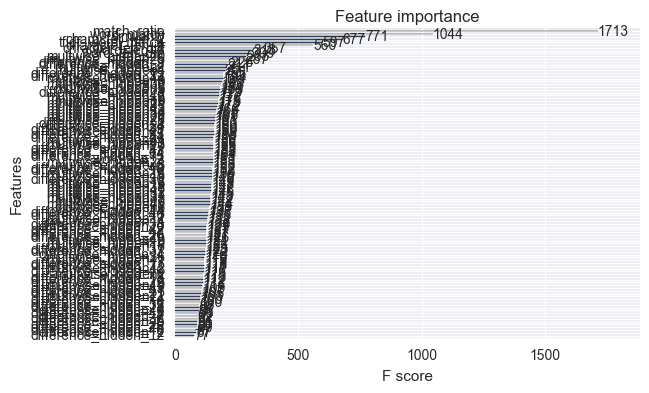

In [55]:
#Train XGBoost
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 7

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=50, verbose_eval=10)

xgb.plot_importance(bst)

In [11]:
#Train XGBoost
import xgboost as xgb

# Grid search

etas = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.5]
max_depths = [3, 5, 7, 9]


for eta in etas:
    for max_depth in max_depths:
        print('eta: ' + str(eta))
        print('max_depth: ' + str(max_depth))
        # Set our parameters for xgboost
        params = {}
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = 'logloss'
        params['eta'] = eta
        params['max_depth'] = max_depth

        d_train = xgb.DMatrix(x_train, label=y_train)
        d_valid = xgb.DMatrix(x_valid, label=y_valid)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]

        bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)
        name_model = 'xgboost_' + str(eta) + '_' + str(max_depth)
        bst.save_model(name_model)

eta: 0.01
max_depth: 3
[0]	train-logloss:0.687437	valid-logloss:0.687469
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.63596	valid-logloss:0.636245
[20]	train-logloss:0.593012	valid-logloss:0.593515
[30]	train-logloss:0.556902	valid-logloss:0.557603
[40]	train-logloss:0.526262	valid-logloss:0.52713
[50]	train-logloss:0.499886	valid-logloss:0.500903
[60]	train-logloss:0.477087	valid-logloss:0.478221
[70]	train-logloss:0.457468	valid-logloss:0.458708
[80]	train-logloss:0.440407	valid-logloss:0.44174
[90]	train-logloss:0.425408	valid-logloss:0.426837
[100]	train-logloss:0.412072	valid-logloss:0.413588
[110]	train-logloss:0.400385	valid-logloss:0.401972
[120]	train-logloss:0.390164	valid-logloss:0.391812
[130]	train-logloss:0.381134	valid-logloss:0.382841
[140]	train-logloss:0.373154	valid-logloss:0.37491
[150]	train-logloss:0.366017	valid-logloss:0.36782
[160]	trai

In [17]:
# Save model
bst.save_model('models/xgboost_m1.model')

# Test

In [12]:
df_test = pd.read_csv('test.csv')

In [62]:
len(df_test)

2345796

In [14]:

# Compute features for test set and save in pickles for every chunk
max_length = 15

test_ids = df_test['test_id'].values

start = 9
end = 17
idx = 0
    
for i in range(start, end):
    print(i)
    # Load test pickles
    with open('pickles/X_test_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_1 = pickle.load(handle)
    with open('pickles/X_test_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_2 = pickle.load(handle) 
        
    # Create dataframe with features
    x_test = pd.DataFrame()
    
    x_test['word_match'] = df_test.iloc[idx:(idx + len(X_test_1))].apply(word_match_share, axis=1, raw=True)
    x_test['tfidf_word_match'] = df_test[idx:(idx + len(X_test_1))].apply(tfidf_word_match_share, axis=1, raw=True)
    x_test['noun_match'] = get_noun_match(df_test.iloc[idx:(idx + len(X_test_1))])
    x_test['character_len_1'], x_test['character_len_2'] = get_character_len(df_test.iloc[idx:(idx + len(X_test_1))])
    x_test['word_len_1'], x_test['word_len_2'] = get_word_len(df_test.iloc[idx:(idx + len(X_test_1))])
    x_test['match_ratio'] = get_match_ratio(df_test.iloc[idx:(idx + len(X_test_1))])
    #x_test['z_tfidf_sum1'], x_test['z_tfidf_sum2'], x_test['z_tfidf_len1'], x_test['z_tfidf_len2'], x_test['z_tfidf_mean1'], x_test['z_tfidf_mean2'] = get_tfidf_aux(df_test.iloc[idx:(idx + len(X_test_1))], tfidf)
    
    x_test['test_id'] = test_ids[idx:(idx + len(X_test_1))]
    
    #Falta las de similarity y embeddings
    with open('pickles/x_test_' + str(i) + '.pickle', 'wb') as handle:
        pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    idx += len(X_test_1)
    
    print('Created features for file ' + str(i))
    
    



9
Computing noun match feature...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Computing character len feature...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Computing word length feature...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Computing match ration feature...


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Created features for file 9
10
Computing noun match feature...
Computing character len feature...
Computing word length feature...
Computing match ration feature...
Created features for file 10
11
Computing noun match feature...
Computing character len feature...
Computing word length feature...
Computing match ration feature...
Created features for file 11
12
Computing noun match feature...
Computing character len feature...
Computing word length feature...
Computing match ration feature...
Created features for file 12
13
Computing noun match feature...
Computing character len feature...
Computing word length feature...
Computing match ration feature...
Created features for file 13
14
Computing noun match feature...
Computing character len feature...
Computing word length feature...
Computing match ration feature...
Created features for file 14
15
Computing noun match feature...
Computing character len feature...
Computing word length feature...
Computing match ration feature...
Creat

In [15]:
# Me he quedado aqui TOOD
# Compute tf-idf features for test set and save in pickles for every chunk

test_ids = df_test['test_id'].values

start = 0
end = 51
idx = 0
for i in range(start, end):
    print(i)
    # Load test pickles
    with open('pickles/X_test_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_1 = pickle.load(handle)
    with open('pickles/X_test_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_2 = pickle.load(handle) 
        
    # Create dataframe with features
    x_test = pd.DataFrame()
    

    x_test['z_tfidf_sum1'], x_test['z_tfidf_sum2'], x_test['z_tfidf_len1'], x_test['z_tfidf_len2'], x_test['z_tfidf_mean1'], x_test['z_tfidf_mean2'] = get_tfidf_aux(df_test.iloc[idx:(idx + len(X_test_1))], tfidf)
    
    x_test['test_id'] = test_ids[idx:(idx + len(X_test_1))]
    
    #Falta las de similarity y embeddings
    with open('pickles/x_test_tfidf_f_' + str(i) + '.pickle', 'wb') as handle:
        pickle.dump(x_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    idx += len(X_test_1)
    
    print('Created features for file ' + str(i))
    
    



16


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [56]:

# Make predictions in chunks 

#bst = xgb.Booster({'nthread':4}) #init model
#bst.load_model("xgboost_m1.model") # load data

features = ['word_match', 'tfidf_word_match', 'similarity', 'difference_hidden', 'multwise_hidden']
#features = ['word_match', 'tfidf_word_match', 'similarity', 'character_len', 'word_len', 'match_ratio', 'difference_hidden', 'multwise_hidden']
features = ['word_match', 'tfidf_word_match', 'similarity', 'character_len', 'word_len', 'match_ratio', 'difference_hidden', 'multwise_hidden']

word_matches = df_test.apply(word_match_share, axis=1, raw=True)
tfidf_word_matches = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
if 'noun_match' in features:
    noun_match = get_noun_match(df_test)
if 'character_len' in features:
    character_len_1, character_len_2, character_len_diff = get_character_len(df_test)
if 'word_len' in features:
    word_len_1, word_len_2, word_len_diff = get_word_len(df_test)
if 'match_ratio' in features:
    match_ratio = get_match_ratio(df_test)
if 'tfidf_aux' in features:
    tfidf_sum1, tfidf_sum2, tfidf_len1, tfidf_len2, tfidf_mean1, tfidf_mean2 = get_tfidf_aux(df_test)
if 'features_with_embeddings' in features:
    bow_sum1, bow_sum2, bow_mean1, bow_mean2, cosine_sim, hamming, pearson = get_features_with_embeddings(df_test)

    
test_ids = df_test['test_id'].values

num_test_files = 51
idx = 0
for i in range(num_test_files):
    print(i)
    # Load test pickles
    with open('pickles/X_test_1_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_1 = pickle.load(handle)
    with open('pickles/X_test_2_GoogleEmbeddings_' + str(max_length) + '_file_' + str(i) + '.pickle', 'rb') as handle:
        X_test_2 = pickle.load(handle) 
    
    
    # Create dataframe to predict this chunk
    x_test = pd.DataFrame()
    
    if 'word_match' in features:
        x_test['word_match'] = word_matches[idx:(idx + len(X_test_1))]
    if 'tfidf_word_match' in features:
        x_test['tfidf_word_match'] = tfidf_word_matches[idx:(idx + len(X_test_1))]
    
    if 'noun_match' in features:
        x_test['noun_match'] = noun_match[idx:(idx + len(X_test_1))]
    if 'character_len' in features:
        x_test['character_len_1'] = character_len_1[idx:(idx + len(X_test_1))]
        x_test['character_len_2'] = character_len_2[idx:(idx + len(X_test_1))]
        x_test['chracter_len_diff'] = character_len_diff[idx:(idx + len(X_test_1))]
    if 'word_len' in features:
        x_test['word_len_1'] = word_len_1[idx:(idx + len(X_test_1))]
        x_test['word_len_2'] = word_len_2[idx:(idx + len(X_test_1))]
        x_test['word_len_diff'] = word_len_diff[idx:(idx + len(X_test_1))]
    if 'match_ratio' in features:
        x_test['match_ratio'] = match_ratio[idx:(idx + len(X_test_1))]
    if 'tfidf_aux' in features:
        x_test['tfidf_sum1'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['tfidf_sum2'] = tfidf_sum2[idx:(idx + len(X_test_1))]
        x_test['tfidf_len1'] = tfidf_len1[idx:(idx + len(X_test_1))]
        x_test['tfidf_len2'] = tfidf_len2[idx:(idx + len(X_test_1))]
        x_test['tfidf_mean1'] = tfidf_mean1[idx:(idx + len(X_test_1))]
        x_test['tfidf_mean2'] = tfidf_mean2[idx:(idx + len(X_test_1))]
    if 'features_with_embeddings' in features:
        x_test['bow_sum1'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['bow_sum2'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['bow_mean1'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['bow_mean2'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['cosine_sim'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['hamming'] = tfidf_sum1[idx:(idx + len(X_test_1))]
        x_test['pearson'] = tfidf_sum1[idx:(idx + len(X_test_1))]
    
    if 'similarity' in features:
        # Compute similarities
        similarities_batch, h1, h2 = model.get_distances_and_hidden(X_test_1, X_test_2, [], checkpoint_path)
        x_test['similarity'] = similarities_batch
    
    if 'difference_hidden' in features:
        for j in range(difference_hidden.shape[1]):
            difference_hidden = np.abs(h1 - h2)
            x_test['difference_hidden_' + str(j)] = difference_hidden[:,j]
    if 'multwise_hidden' in features:
        for j in range(difference_hidden.shape[1]):
            multwise_hidden = h1 * h2
            x_test['multwise_hidden' + str(j)] = multwise_hidden[:,j]
    
        
    # Make predictions for this file
    d_test = xgb.DMatrix(x_test)
    p_test = bst.predict(d_test)

    sub = pd.DataFrame()
    sub['test_id'] = test_ids[idx:(idx + len(X_test_1))]
    sub['is_duplicate'] = p_test
    sub.to_csv('kaggle/xgb_predictions_' + str(i) + '.csv', index=False)
    
    idx += len(X_test_1)
    
    print('Created predictions for file ' + str(i))
    




Computing character len feature...
Computing word length feature...
Computing match ration feature...
0
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 0
1
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 1
2
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 2
3
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 3
4
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 4
5
load model: checkpoints/lstm-50-1-128-adam-28000000-manhattan-20170409-202358/best_model/model_best.ckpt-6758400
Created predictions for file 5
6
load model: checkpoi

In [57]:
import time 

# Join all csv in one
print('Join all csvs...')

fout=open("kaggle/xgb_predictions_joined_" + time.strftime("%Y%m%d-%H%M%S") + ".csv","a")

with open("kaggle/xgb_predictions_0.csv", "r+") as f:
    for line in f:
        fout.write(line)
# for the rest of files we skip the headers
for i in range(1, num_test_files):
    print(i)
    j = 0
    with open("kaggle/xgb_predictions_" + str(i) + ".csv", "r+") as f:
        for line in f:
            if j > 0:
                fout.write(line)
            j += 1


fout.close()


Join all csvs...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [59]:
df_test

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


In [61]:
df_test.iloc[2:4]

,test_id,question1,question2
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?


# Adapt predictions to test set

In [43]:
def prob_train_2_test(prob):
    a = 0.165 / 0.37
    b = (1 - 0.165) / (1 - 0.37)
    new_prob = a * prob / (a * prob + b * (1 - prob))
    return new_prob

In [58]:
fout=open("kaggle/xgb_predictions_prob_adapated_" + time.strftime("%Y%m%d-%H%M%S") + ".csv","a")

j = 0
with open("kaggle/xgb_predictions_joined_20170419-113513.csv", "r+") as f:
    for line in f:
        if j > 0:
            line_split = line.split(',')
            test_id = line_split[0]
            new_prob = prob_train_2_test(float(line_split[1]))
            fout.write(str(test_id) + ',' + str(new_prob) + '\n')
        else:
            fout.write(line)
        j += 1
fout.close()

In [27]:
j

2345797